# First attempts at supervised classification for flares

I am using only the data that were in visual_data.fits, which had a cutoff at CON_NSIGMA > 5. Flares are defined as having the FLARE variable = 'Y' (FLARE='-' were treated as no flare). Only the 499 second observations are included. I exported the data csv files and cross-matched on extras-ID.

I split the data into train-test randomly, stratified. I run a two-class supervised classification. I evaluate the performance using the f1 score, the accuracy, and by looking at pecision-recall curve.

I train a FIGS model to see whether I get a decent performance with some interpretability.

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from imodels import FIGSClassifier, FIGSRegressor, get_clean_dataset, FIGSClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier as xgb
import seaborn as sns

### Reading in the data

In [2]:
visual_data = pd.read_csv("visual_data.csv")

In [3]:
visual_data.shape

(13855, 10)

In [4]:
complete_data = pd.read_csv("complete_data_499.csv")

In [5]:
cdf = pd.read_csv("cdf_499.csv")

In [6]:
cdf['EXTRAS_ID'] = np.array([str(s)[2:-1] for s in cdf['EXTRAS_ID']])

In [7]:
cdf.head()

Unnamed: 0         OBS_ID  SRC_NUM  BIN_SIZE     F_VAR  F_VAR_ERR  \
0           2  b'0000110101'        1       499  0.692592   0.165601   
1           6  b'0000110101'        2       499  0.997198   0.264032   
2          10  b'0000110101'        3       499  0.788664   0.615132   
3          14  b'0000110101'        4       499  1.926109   1.752167   
4          18  b'0000110101'        5       499  1.662160   0.516661   

            AVE       AVE_ERR         STDEV          SKEW  ...      FLUX_P40  \
0  1.350140e-13  1.527083e-14  1.891364e-13 -1.577253e-39  ...  1.025936e-13   
1  3.009117e-14  8.882952e-15  9.760700e-14 -2.143861e-40  ...  2.122912e-14   
2  2.041009e-14  6.064366e-15  6.238247e-14  1.746324e-40  ...  4.900570e-15   
3 -9.831734e-15  6.184388e-15  5.308298e-14 -9.130072e-41  ... -2.952255e-14   
4 -4.676036e-15  4.837585e-15  4.365292e-14  1.337472e-40  ... -9.115572e-15   

       FLUX_P50      FLUX_P60    FLUX_P67.5      FLUX_P75    FLUX_P82.5  \
0  1.669971e-13  2.281533e-13  2.736146e-13  3.228643e-13  3.818557e-13   
1  5.609994e-14  9.367392e-14  1.234087e-13  1.561170e-13  1.963942e-13   
2  3.078012e-14  5.932018e-14  8.181361e-14  1.069676e-13  1.374425e-13   
3 -9.982597e-15  1.049904e-14  2.792021e-14  4.863727e-14  7.406276e-14   
4  5.942725e-15  2.325977e-14  3.944744e-14  6.052905e-14  9.064565e-14   

       FLUX_P90      FLUX_P95      FLUX_P99           EXTRAS_ID  
0  4.668250e-13  5.680305e-13  7.785595e-13  0000110101_001_499  
1  2.550528e-13  3.274976e-13  5.067174e-13  0000110101_002_499  
2  1.812201e-13  2.337048e-13  3.657630e-13  0000110101_003_499  
3  1.103176e-13  1.536351e-13  2.680498e-13  0000110101_004_499  
4  1.358205e-13  1.877717e-13  3.699771e-13  0000110101_005_499  

[5 rows x 55 columns]

In [8]:
(complete_data["F_PROB_FLCON"] == -1000).sum()

247

### Cross matching on EXTRAS_ID and prepping

This was a bit of a pain using the whole complete_data because it would run out of memory on my laptop, but it works now by restricting to complete_data_499 only.

In [9]:
data_visual_complete = pd.merge(visual_data, complete_data, how='inner', on = 'EXTRAS_ID')
data = pd.merge(data_visual_complete, cdf, how='inner', on = 'EXTRAS_ID')

Let us see the names of all the columns in the combined dataframe

In [10]:
retain = np.zeros(len(data.columns), dtype=bool)
retain_nomodels = np.copy(retain)
for i, c in zip(range(len(data.columns)), data.columns):
    if (i > 23) and (i < 145):
        if not (c.endswith('TS') or c.endswith('NHP') or c.startswith('F_NSIGMA')):
            retain[i] = True
            retain_nomodels[i] = True
            if ('DIP' in c) or ('EC' in c) or ('FL' in c):
                retain_nomodels[i] = False
    print(i, c)

retain[179:224] = True
retain[143] = False
retain_nomodels[179:224] = True
retain_nomodels[143] = False
print(retain)
print(retain_nomodels)

#DIP1, DIP, EC1, EC, FL

0 Unnamed: 0_x
1 OBS_ID_x
2 SRC_NUM_x
3 DIPECLPER
4 MULTIDEP
5 FLARE
6 MULTIFL
7 FIT
8 GOOD_FIT
9 EXTRAS_ID
10 Unnamed: 0_y
11 3XMM
12 4XMM
13 PPS
14 OBS_ID_y
15 SRC_NUM_y
16 BIN_SIZE_x
17 PRED_CTS_INREG
18 PN_RAWCTS
19 M1_RAWCTS
20 M2_RAWCTS
21 TSTART_LC
22 TSTOP_LC
23 N_BINS
24 AVERAGE
25 AVERAGE_ERR
26 ST_DEV
27 MEDIAN_x
28 MED_ABS_DEV_x
29 CON_TS
30 CON_NHP
31 CON_NSIGMA
32 CON_CON
33 CON_CON_ERR
34 LIN_TS
35 LIN_NHP
36 LIN_NSIGMA
37 LIN_CON
38 LIN_CON_ERR
39 LIN_LIN
40 LIN_LIN_ERR
41 QU_TS
42 QU_NHP
43 QU_NSIGMA
44 QU_CON
45 QU_CON_ERR
46 QU_LIN
47 QU_LIN_ERR
48 QU_QU
49 QU_QU_ERR
50 EXP_TS
51 EXP_NHP
52 EXP_NSIGMA
53 EXP_CON
54 EXP_CON_ERR
55 EXP_NOR
56 EXP_NOR_ERR
57 EXP_EXP
58 EXP_EXP_ERR
59 DIP1_TS
60 DIP1_NHP
61 DIP1_NSIGMA
62 DIP1_TMIN
63 DIP1_TMIN_ERR
64 DIP1_DT
65 DIP1_DT_ERR
66 DIP1_FLMIN
67 DIP1_FLMIN_ERR
68 DIP1_FLMAX
69 DIP1_FLMAX_ERR
70 DIP_TS
71 DIP_NHP
72 DIP_NSIGMA
73 DIP_TMIN
74 DIP_TMIN_ERR
75 DIP_DT
76 DIP_DT_ERR
77 DIP_FLMIN
78 DIP_FLMIN_ERR
79 DIP_FLMAX
80 DIP

Preparing the final dataset for train-test splitting. I am turning 'FLARE' into a binary variable and selecting only certain columns (from 24 to 144, see to what this corresponds in terms of variable names by looking above). I then split the dataset into train-test. The split is stratified given how unbalanced the data set is.

In [11]:
select_nomodel = retain_nomodels[retain]
y = data.copy()['FLARE']
y[y == '-'] = 'N'
y = (y=='Y')
X = data.copy().iloc[:,retain]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)
X_train_nomodel, X_test_nomodel, y_train_nomodel, y_test_nomodel = X_train.iloc[:,select_nomodel], X_test.iloc[:,select_nomodel], y_train, y_test

In [12]:
X_train_nomodel.columns

Index(['AVERAGE', 'AVERAGE_ERR', 'ST_DEV', 'MEDIAN_x', 'MED_ABS_DEV_x',
       'CON_NSIGMA', 'CON_CON', 'CON_CON_ERR', 'LIN_NSIGMA', 'LIN_CON',
       'LIN_CON_ERR', 'LIN_LIN', 'LIN_LIN_ERR', 'QU_NSIGMA', 'QU_CON',
       'QU_CON_ERR', 'QU_LIN', 'QU_LIN_ERR', 'QU_QU', 'QU_QU_ERR',
       'EXP_NSIGMA', 'EXP_CON', 'EXP_CON_ERR', 'EXP_NOR', 'EXP_NOR_ERR',
       'EXP_EXP', 'EXP_EXP_ERR', 'F_PROB_LINCON', 'F_PROB_QUCON',
       'F_PROB_QULIN', 'F_PROB_EXPCON', 'BB_MAXBLOCKS', 'BB_MB_MINTIME',
       'SKEW', 'KURT', 'RELVAR', 'AMPLIT', 'MEDIAN_y', 'MED_ABS_DEV_y',
       'MEDMAXOFF', 'TFRAC_BEL1E', 'TFRAC_ABO1E', 'TFRAC_BEL3E', 'TFRAC_ABO3E',
       'TFRAC_BEL5E', 'TFRAC_ABO5E', 'TFRAC_MID20', 'TFRAC_BEL1S',
       'TFRAC_ABO1S', 'TFRAC_BEL3S', 'TFRAC_ABO3S', 'TFRAC_BEL5S',
       'TFRAC_ABO5S', 'TFRAC_BEL1MAD', 'TFRAC_ABO1MAD', 'TFRAC_BEL3MAD',
       'TFRAC_ABO3MAD', 'TFRAC_BEL5MAD', 'TFRAC_ABO5MAD', 'FIT_AVE',
       'FIT_AVE_ERR', 'FIT_SIGMA', 'FIT_SIGMA_ERR', 'FLUX_P01', 'FLUX_P05',
  

#### Comparing the training data frame with model-dependent quantites to the one without
It looks like I am losing 136-78 features. Whoa.

In [13]:
for c in X_train.columns:
    print(c)

AVERAGE
AVERAGE_ERR
ST_DEV
MEDIAN_x
MED_ABS_DEV_x
CON_NSIGMA
CON_CON
CON_CON_ERR
LIN_NSIGMA
LIN_CON
LIN_CON_ERR
LIN_LIN
LIN_LIN_ERR
QU_NSIGMA
QU_CON
QU_CON_ERR
QU_LIN
QU_LIN_ERR
QU_QU
QU_QU_ERR
EXP_NSIGMA
EXP_CON
EXP_CON_ERR
EXP_NOR
EXP_NOR_ERR
EXP_EXP
EXP_EXP_ERR
DIP1_NSIGMA
DIP1_TMIN
DIP1_TMIN_ERR
DIP1_DT
DIP1_DT_ERR
DIP1_FLMIN
DIP1_FLMIN_ERR
DIP1_FLMAX
DIP1_FLMAX_ERR
DIP_NSIGMA
DIP_TMIN
DIP_TMIN_ERR
DIP_DT
DIP_DT_ERR
DIP_FLMIN
DIP_FLMIN_ERR
DIP_FLMAX
DIP_FLMAX_ERR
DIP_PER
DIP_PER_ERR
EC1_NSIGMA
EC1_TIN
EC1_TIN_ERR
EC1_TFIN
EC1_TFIN_ERR
EC1_FLMIN
EC1_FLMIN_ERR
EC1_FLMAX
EC1_FLMAX_ERR
EC_NSIGMA
EC_T1
EC_T1_ERR
EC_T2
EC_T2_ERR
EC_FL1
EC_FL1_ERR
EC_FL2
EC_FL2_ERR
EC_PER
EC_PER_ERR
FL_NSIGMA
FL_CON
FL_CON_ERR
FL_DFL
FL_DFL_ERR
FL_TMAX
FL_TMAX_ERR
FL_DT
FL_DT_ERR
FL_RT
FL_RT_ERR
F_PROB_LINCON
F_PROB_QUCON
F_PROB_QULIN
F_PROB_EXPCON
F_PROB_DIP1CON
F_PROB_DIPCON
F_PROB_DIP1DIP
F_PROB_EC1CON
F_PROB_ECCON
F_PROB_EC1EC
F_PROB_FLCON
BB_MAXBLOCKS
BB_MB_MINTIME
SKEW
KURT
RELVAR
AMPLIT
MEDIAN_y
ME

In [14]:
X_train_nomodel.shape

(11084, 78)

### Training XGBoost, a black box model

Now let us fit an XGBoost model to the training data and evaluate its predictions on the test data. Note that I am not optimizing the model's hyperparameters.

In [15]:
model_xgb = xgb(n_estimators=1000, random_state=888)
model_xgb_nomodel = xgb(n_estimators=1000, random_state=888)  

model_xgb.fit(X_train, y_train)  
preds_xgb = model_xgb.predict(X_test)

model_xgb_nomodel.fit(X_train_nomodel, y_train_nomodel)  
preds_xgb_nomodel = model_xgb_nomodel.predict(X_test_nomodel)

In [16]:
from sklearn.metrics import precision_recall_curve as prc
preds_proba_xgb = model_xgb.predict_proba(X_test)
precision_recall_xgboost = prc(y_test, preds_proba_xgb[:,1])

preds_proba_xgb_nomodel = model_xgb_nomodel.predict_proba(X_test_nomodel)
precision_recall_xgboost_nomodel = prc(y_test_nomodel, preds_proba_xgb_nomodel[:,1])

In [17]:
accuracy_xgb = accuracy_score(y_test, preds_xgb)
accuracy_xgb

0.9682425117286179

In [18]:
accuracy_xgb_nomodel = accuracy_score(y_test_nomodel, preds_xgb_nomodel)
accuracy_xgb_nomodel

0.954168170335619

The accuracy score is deceivingly high. The dataset is very unbalanced, so predicting always no flare would yield an accuracy of:

In [19]:
sum(1-y_test)/len(y_test)

0.9231324431613136

Clearly we need a better metric for evaluating the classifier. Here is the raw confusion matrix:

In [20]:
confusion_matrix(y_test, preds_xgb)

array([[2521,   37],
       [  51,  162]])

In [21]:
confusion_matrix(y_test_nomodel, preds_xgb_nomodel)

array([[2516,   42],
       [  85,  128]])

In [22]:
from sklearn.metrics import precision_recall_curve

The precision score (aka purity in astro catalogs) measures what fraction of actual flares was found among the sources tagged as flares. It is pretty decent:

In [23]:
precision_xgb = precision_score(y_test, preds_xgb)
precision_xgb

0.8140703517587939

In [24]:
precision_xgb_nomodel = precision_score(y_test_nomodel, preds_xgb_nomodel)
precision_xgb_nomodel

0.7529411764705882

On the other hand the recall score (completeness for astronomers I guess) is not so good:

In [25]:
recall_xgb = recall_score(y_test, preds_xgb)
recall_xgb

0.7605633802816901

In [26]:
recall_xgb_nomodel = recall_score(y_test_nomodel, preds_xgb_nomodel)
recall_xgb_nomodel

0.6009389671361502

The recall score is the fraction of actual flares we correctly tag as flares. We miss one in four.

The F1 score summarizes both recall and precision by taking their harmonic mean. Here it is:

In [27]:
f1_xgb = f1_score(y_test, preds_xgb)
f1_xgb

0.7864077669902911

In [28]:
f1_xgb_nomodel = f1_score(y_test_nomodel, preds_xgb_nomodel)
f1_xgb_nomodel

0.6684073107049608

## Training logistic regression

(0.5, 1.0)

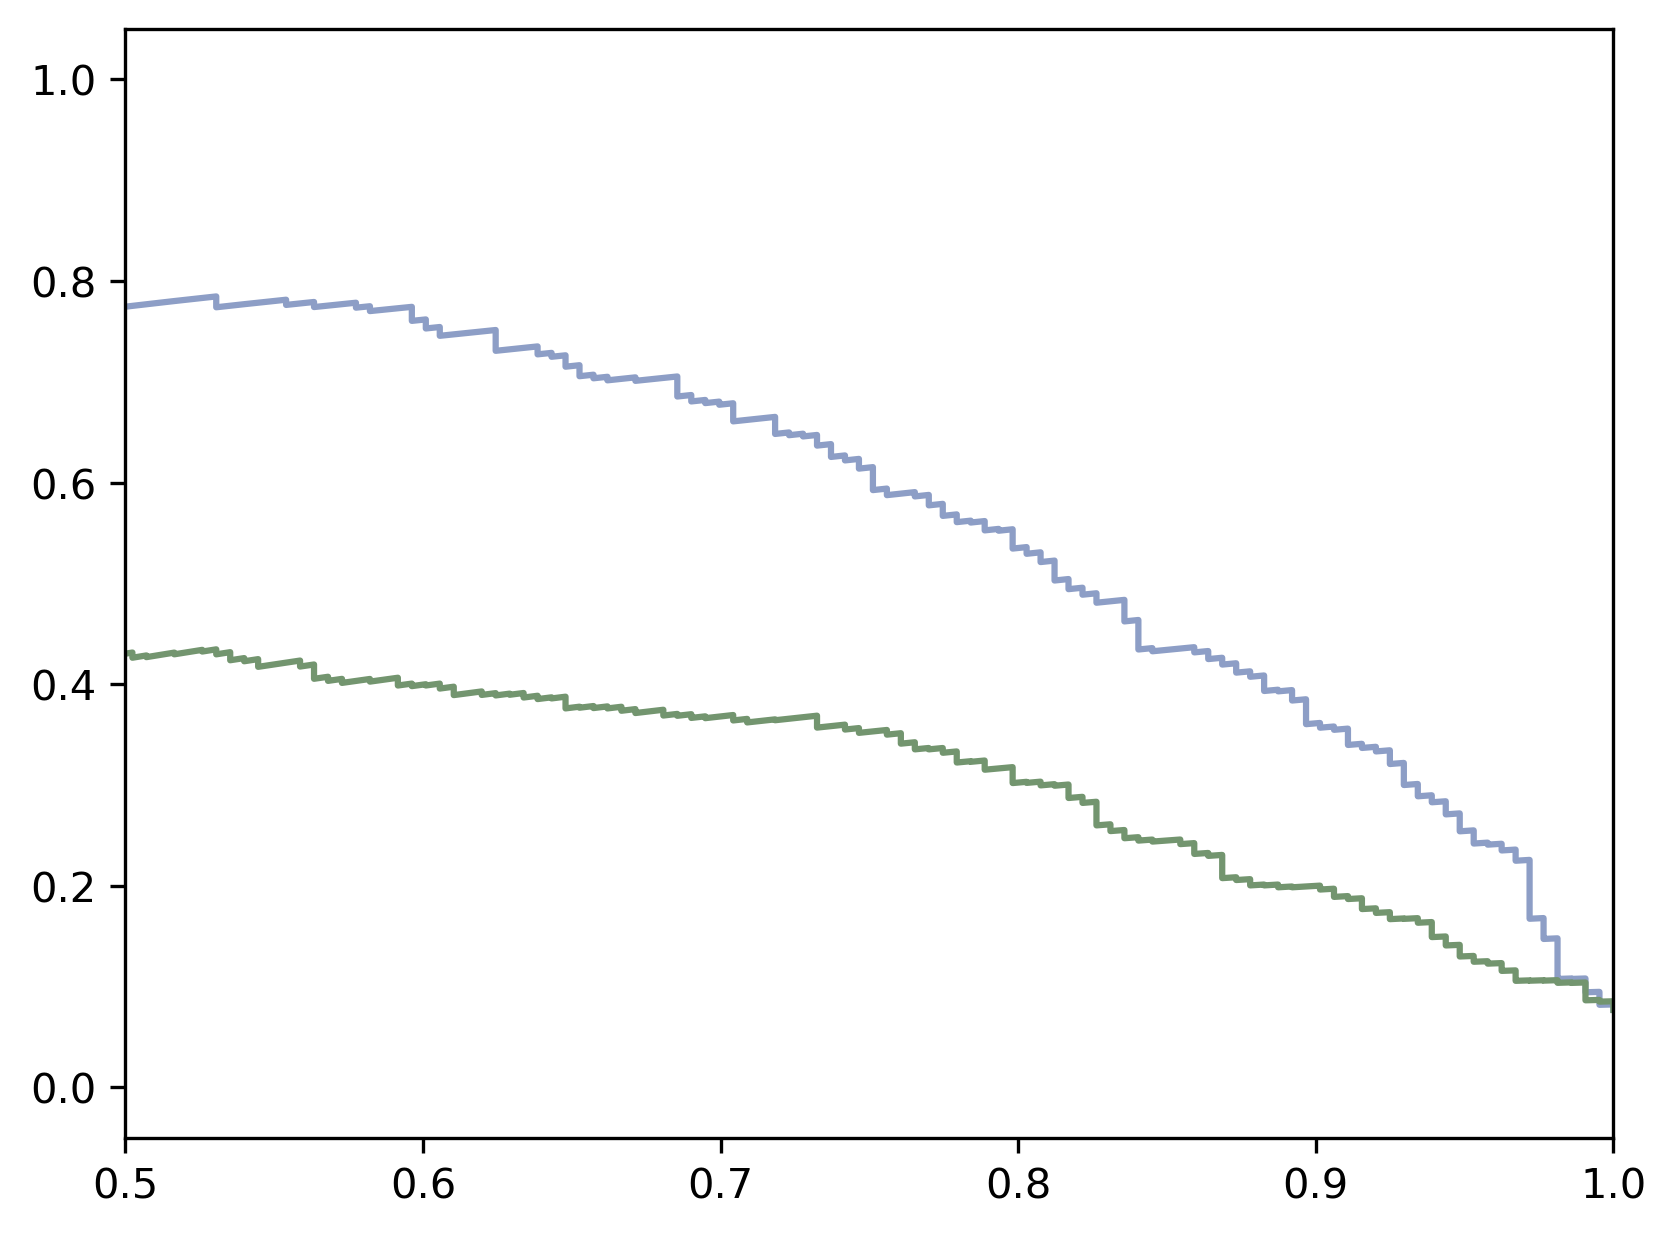

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train_nomodel, y_train_nomodel)
logregpreds = logreg.predict(X_test_nomodel) 
logregpreds_proba = logreg.predict_proba(X_test_nomodel)

precision_recall_logreg_nomodel = prc(y_test_nomodel, logregpreds_proba[:,1])
plt.plot(precision_recall_xgboost_nomodel[1], precision_recall_xgboost_nomodel[0], color = "#8D9EC6")
plt.plot(precision_recall_logreg_nomodel[1], precision_recall_logreg_nomodel[0], color = "#73956F")
plt.xlim([0.5,1])

### sparse logreg on all feature interactions

In [30]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

def get_interactions(X):
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    return poly.fit_transform(X)

def get_sparse_logistic_regression(X, y, C):
    clf = LogisticRegression(penalty='l1', C=C, solver='saga', max_iter=10000)
    clf.fit(X, y)
    return clf


X_interact = get_interactions(X_train_nomodel)

In [31]:
X_interact.shape

(11084, 3081)

## Training FIGS

In [ ]:
rules_list = 5 + np.zeros(3)
print(rules_list)
trees_list = [2,3,4]
print(trees_list)
FIGSmodel = FIGSClassifierCV(n_rules_list = rules_list, n_trees_list = trees_list, cv = 5, scoring='roc_auc') #despite giving it the seed here it is not deterministic still
FIGSmodel.fit(X_train_nomodel, y_train_nomodel)   
FIGSpreds = FIGSmodel.predict(X_test_nomodel) 
FIGSpreds_proba = FIGSmodel.predict_proba(X_test_nomodel)

feat_names = X_train_nomodel.columns
FIGSmodel.figs.plot(feature_names=feat_names, label='all', impurity=True)

In [ ]:
print(FIGSmodel.figs)
precision_recall_FIGS_nomodel = prc(y_test_nomodel, FIGSpreds_proba[:,1])
plt.plot(precision_recall_xgboost_nomodel[1], precision_recall_xgboost_nomodel[0], color = "#8D9EC6")
plt.plot(precision_recall_FIGS_nomodel[1], precision_recall_FIGS_nomodel[0], color = "#F79F79")
plt.plot(precision_recall_logreg_nomodel[1], precision_recall_logreg_nomodel[0], color = "#73956F")
plt.xlim([0.5,1])

In [ ]:
FIGSmodel.figs

### fake datasets for testing out figs

In [ ]:
s = 1000
a = np.random.uniform(size=s)
b = np.random.uniform(size=s)
c = np.random.uniform(size=s)
y = np.sign(a - 0.6) > 0.5
#y[c < 0.3] = ~y[c < 0.3]
prova_train = pd.DataFrame.from_dict(data={"a":a, "b":b, "c":c})

FIGSmodel_prova = FIGSClassifierCV(n_rules_list = [10,10,10,10], n_trees_list = [1,2,3,4], cv = 5, scoring='precision')

#FIGSmodel_prova.figs

#FIGSmodel_prova = FIGSClassifier(max_rules=5, max_trees=2, max_features='sqrt', random_state=888) #despite giving it the seed here it is not deterministic still
FIGSmodel_prova.fit(prova_train, y)
FIGSmodel_prova.figs.plot(feature_names=prova_train.columns, label='all', impurity=True)
FIGSmodel_prova.figs

plt.scatter(a,b,c=y,cmap='summer')
plt.show()
y